In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal.windows import tukey

### Question 1
### (a)
From the lecture notes, we know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, we first calculate the transfer functions $G_{\phi}(f)$ and $G_{\theta}(f)$ and then we return the sdf evaluated at a given $f$ (we require $f$ to be in $[-1/2, 1/2]$ for the sdf to be non-zero).

In [2]:
def S_ARMA(f, phis, thetas, sigma2):
    """Input: 
    f: vector of frequences at which it should be evaluated
    phis: the list [phi_{1,p},..., phi_{p,p}]
    thetas: the list [theta_{1,q},..., theta_{q,q}]
    sigma2: a scalar for the variance of the white noise
    Output:
    The theoretical spectral density function for a ARMA(p,q) process evaluated at f."""

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize the two sums 
    G_theta = 1
    G_phi = 1

    # sum_q = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
    for i in range(1,p+1):
        G_phi = G_phi - phis[i-1]*np.e**(-1j*2*np.pi*f*i)
    
    # sum_p = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
    for i in range(1,q+1):
        G_theta = G_theta - thetas[i-1]*np.e**(-1j*2*np.pi*f*i) 

    # sdf is non-zero only if f is between -1/2 and 1/2
    if -0.5 <= f <= 0.5:
        return sigma2*(abs(G_theta))**2/(abs(G_phi))**2
    # sdf is zero for values outside [-1/2, 1/2]
    else:
        return 0

### (b)
We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2} \quad t>2.
\end{equation*}

In [3]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """Input:
    phis: the list [phi_{1,2}, phi_{2,2}]
    thetas: the list [theta_{1,2}, theta_{2,2}]
    sigma2: a scalar for the variance of the white noise
    N: length of simulated process
    Output: 
    Time series of length N simulated by the ARMA(2,2) process."""
    
    # initialize list recording the values of the stochastic process
    X = [0,0]

    # create list with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = [np.random.normal(0,np.sqrt(sigma2)) for i in range(N+100)]

    # recursively append the values Xt
    for i in range(2,N+100):
        X.append(phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2])
    
    # return only the N values after the first 100
    return X[100:]

### (c)
The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
a[k] = \sum_{k = 0}^{N-1} X[k] e^{-i2\pi f_k (k+1)} = y[k]e^{-i 2\pi f_k}.
\end{equation*}
After obtaining $a[k]$, we have the following estimate of the sdf:
\begin{equation*}
S[k] = \frac{1}{N} \big| a[k] \big|^2.
\end{equation*}
This is calculated for the Fourier frequencies $f_k$, which range from $0$ to $(N-1)/N$, however, in the lecture notes we define the periodogram over $[-1/2, 1/2]$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by moving the first half of the resulting $N$ dimensional vector after the second half, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2]$. We do this so that the resulting periodogram is compatible with our definition in the notes. 

In [4]:
def periodogram(X):
    """Input:
    X: time series
    Output:
    The periodogram at the Fourier frequencies for X."""
    
    N = len(X)
    y = fft(X)  # produces an array of length N of the Fourier transform of X at f = k/N

    # create an array with the Fourier frequencies
    f_k = np.array([i/N for i in range(N)])
    
    # obtain the needed array a[k] as descibed above
    a = y
    for i in range(N):
        a[i] = a[i]*np.e**(-1j*2*np.pi*f_k[i])
    
    # transform the array into a list
    S = list(a)

    # compute the squared absolute value and divide by N
    for i in range(N):
        S[i] = abs(S[i])**2/N
    
    # return the periodogram by swapping the first and second halves of S
    return S[int(N/2):] + S[0:int(N/2)]

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper. 

In [5]:
def direct(X,p):
    """
    Input:
    X: time series
    p: variable for cosine taper
    Output:
    Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X."""
    
    N = len(X)
    h = [1 for i in range(N)]
    width = int(np.floor(p*(N-1))/2)

    for i in range(0, width+1):
        h[i] = 0.5*(1 - np.cos(2*np.pi*i/(p*(N-1))))

    for i in range(int(width+1), N-1-width):
        h[i] = 1

    for i in range(N-width-1,N):
        h[i] = 0.5*(1 - np.cos(2*np.pi*(N-i)/((p*(N-1)))))/2
    
    sum_h = 0
    for i in range(N):
        sum_h += h[i]**2
    #h = h/np.sqrt(sum_h)
    
    m = tukey(N,p)
    y = list(fft([X[i]*h[i] for i in range(N)]))
    z = list(fft([X[i]*m[i] for i in range(N)]))
    for i in range(N):
        y[i] = abs(y[i])**2/N

    for i in range(N):
        z[i] = abs(z[i])**2/N
    return y,z

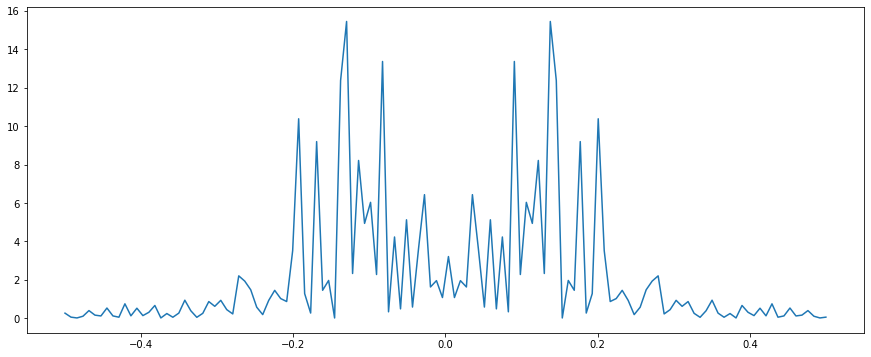

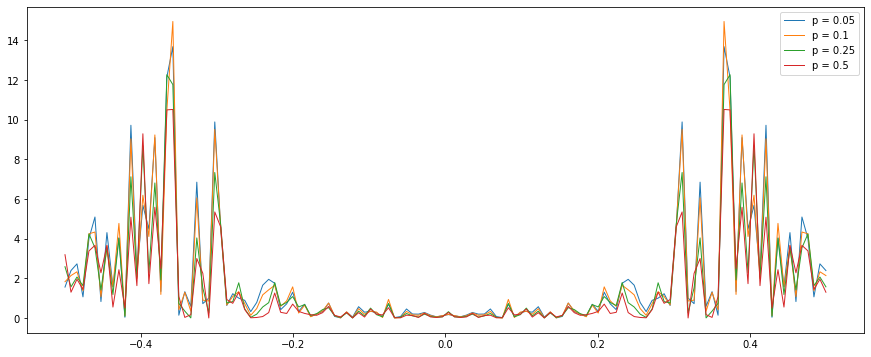

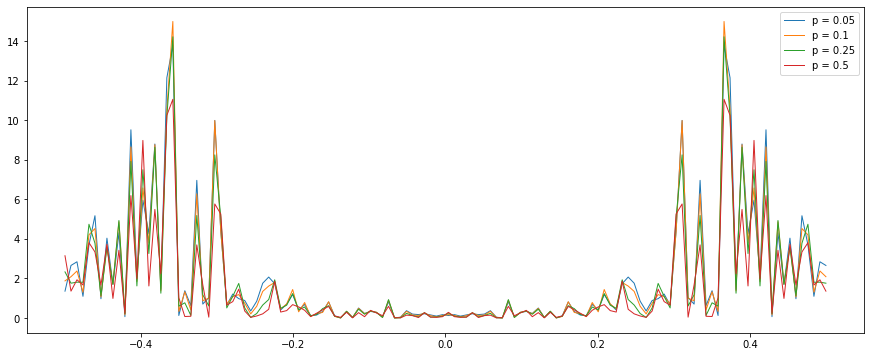

In [6]:
N = 128
X = ARMA22_sim([0.3,-0.4], [-0.5,-0.2], 1, N)


plt.figure(figsize=(15, 6))
t = np.linspace(-0.5,0.5,len(X))
q = periodogram(X)
plt.plot(t,q)
plt.show()

plt.figure(figsize=(15, 6))
for p in [0.05, 0.1, 0.25, 0.5]:
    plt.plot(t,direct(X,p)[0], linewidth = 1,label = f"p = {p}")
#plt.plot(t,q, "k--")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
for p in [0.05, 0.1, 0.25, 0.5]:
    plt.plot(t,direct(X,p)[1], linewidth = 1,label = f"p = {p}")
#plt.plot(t,q, "k--")
plt.legend()
plt.show()